In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train = pd.read_csv('train.csv')
train.head(2)

,Year,Month,ProductCategory,Sales(In ThousandDollars)
0,2009,1,WomenClothing,1755.0
1,2009,1,MenClothing,524.0


In [3]:
submission = pd.read_csv('submission.csv')
submission.head(2)

,Year,Month,ProductCategory,Unnamed: 3,Sales(In ThousandDollars)
0,2014,1,WomenClothing,NaN,NaN
1,2014,1,MenClothing,NaN,NaN


In [4]:
submission.drop('Unnamed: 3', axis=1, inplace=True)

## **Base Model**

In [5]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import statsmodels.api as sma

In [6]:
encoded_data = pd.get_dummies(data=train,columns=['ProductCategory'], drop_first=True)
encoded_data.head(2)

,Year,Month,Sales(In ThousandDollars),ProductCategory_OtherClothing,ProductCategory_WomenClothing
0,2009,1,1755.0,0,1
1,2009,1,524.0,0,0


In [7]:
train_wtnull = encoded_data.copy()
train_wtnull.dropna(inplace=True)
train_wtnull.isnull().sum()

Year                             0
Month                            0
Sales(In ThousandDollars)        0
ProductCategory_OtherClothing    0
ProductCategory_WomenClothing    0
dtype: int64

In [8]:
X = train_wtnull.drop(['Sales(In ThousandDollars)'], axis=1)
y = train_wtnull['Sales(In ThousandDollars)']

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=10)

In [9]:
lrmodel = LinearRegression()
lrmodel.fit(Xtrain, ytrain)

LinearRegression()

In [10]:
scoreslogreg = cross_val_score(lrmodel, Xtrain, ytrain, cv=10)
print(scoreslogreg)
print("Average R2")
print(np.mean(scoreslogreg))

[0.89975035 0.82147625 0.91212612 0.88201634 0.96542281 0.93237204
 0.84723585 0.93438377 0.96103149 0.86805623]
Average R2
0.90238712558084


In [11]:
ypred_lr = lrmodel.predict(Xtest)

In [12]:
print('Test RMSE:', np.sqrt(mean_squared_error(ytest, ypred_lr)))

Test RMSE: 378.5164261995197


In [13]:
len(ypred_lr)

43

In [14]:
full_model = lrmodel.predict(X)
r2_score(y, full_model)

0.9122093263708361

In [15]:
np.sqrt(mean_squared_error(y,full_model))

342.1651658667953

**Predicting**

In [16]:
submission.head(2)
submit_encoded = pd.get_dummies(data=submission.drop(['Sales(In ThousandDollars)'] , axis=1),columns=['ProductCategory'], drop_first=True)
submit_encoded.head(2)

,Year,Month,ProductCategory_OtherClothing,ProductCategory_WomenClothing
0,2014,1,0,1
1,2014,1,0,0


In [17]:
submit_pred = lrmodel.predict(submit_encoded)
submit_pred

array([3243.94962319,  779.43881432, 1198.29414774, 3292.97773915,
        828.46693028, 1247.3222637 , 3342.00585511,  877.49504624,
       1296.35037966, 3391.03397107,  926.5231622 , 1345.37849562,
       3440.06208703,  975.55127816, 1394.40661158, 3489.09020299,
       1024.57939412, 1443.43472754, 3538.11831895, 1073.60751008,
       1492.4628435 , 3587.14643491, 1122.63562604, 1541.49095946,
       3636.17455087, 1171.663742  , 1590.51907542, 3685.20266683,
       1220.69185796, 1639.54719138, 3734.23078279, 1269.71997392,
       1688.57530734, 3783.25889875, 1318.74808988, 1737.6034233 ])

In [18]:
submit_v1 = pd.DataFrame({"Year": np.arange(1,37), "Sales(In ThousandDollars)":submit_pred})
submit_v1

,Year,Sales(In ThousandDollars)
0,1,3243.949623
1,2,779.438814
2,3,1198.294148
3,4,3292.977739
4,5,828.466930
5,6,1247.322264
6,7,3342.005855
7,8,877.495046
8,9,1296.350380
9,10,3391.033971


submit_v1.to_csv("submit_v1.csv", index = False)

# **Improving Model Accuracy**

In [19]:
encoded_data.head(2)

,Year,Month,Sales(In ThousandDollars),ProductCategory_OtherClothing,ProductCategory_WomenClothing
0,2009,1,1755.0,0,1
1,2009,1,524.0,0,0


In [20]:
train_wtnull.skew().sort_values(ascending=False)

Sales(In ThousandDollars)        1.000355
ProductCategory_OtherClothing    0.732386
ProductCategory_WomenClothing    0.703996
Month                            0.012205
Year                             0.008745
dtype: float64

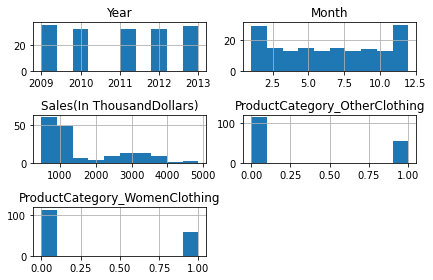

In [21]:
train_wtnull.hist()
plt.tight_layout()
plt.show()

**Transformation (since data is highly skewed)**

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PowerTransformer

In [23]:
pt = PowerTransformer()
train_imputed = pd.DataFrame(pt.fit_transform(Xtrain), columns = Xtrain.columns)
test_imputed  = pd.DataFrame(pt.transform(Xtest)     , columns = Xtest.columns)

In [24]:
train_imputed.shape, test_imputed.shape

((127, 4), (43, 4))

### **Implementing Base Model on Transformed Data**

In [25]:
lrmodel_v1 = LinearRegression()
lrmodel_v1.fit(train_imputed, ytrain)

LinearRegression()

In [26]:
scoreslogreg_v1 = cross_val_score(lrmodel_v1, train_imputed, ytrain, cv=10)
print(scoreslogreg_v1)
print("Average R2")
print(np.mean(scoreslogreg_v1))

[0.90038212 0.82850796 0.91264697 0.88056038 0.96341065 0.93401892
 0.84600784 0.93521306 0.96036004 0.86997859]
Average R2
0.9031086530659798


In [27]:
ypred_transformed = lrmodel_v1.predict(test_imputed)

In [28]:
print('Test RMSE:', np.sqrt(mean_squared_error(ytest, ypred_transformed)))

Test RMSE: 380.55059907747017


**Applying Decision Tree Regressor since Transformation had no Effect on Linear Model**

# `Decision Tree Regressor`

**Default Model**

In [29]:
from sklearn.tree import DecisionTreeRegressor

In [30]:
dtmodel = DecisionTreeRegressor()
dtmodel.fit(train_imputed, ytrain)

DecisionTreeRegressor()

In [31]:
scoresdt = cross_val_score(dtmodel, train_imputed, ytrain, cv=10)
print(scoresdt)
dt_r2 = np.mean(scoresdt)
print("Average R2\n",dt_r2)

[0.97872437 0.96541003 0.96991943 0.93960744 0.98510177 0.98156377
 0.99284378 0.93071379 0.94465147 0.95895764]
Average R2
 0.9647493472962447


In [32]:
ypred_dt = dtmodel.predict(test_imputed)

In [50]:
dt_rmse = np.sqrt(mean_squared_error(ytest, ypred_dt))
print('Test RMSE:', dt_rmse)

Test RMSE: 115.06297567894298


`Inference:`
**The model is clearly overfit but RMSE is reduced** 
**Checking the submission file with this model**

### Preparing Data for Submission

In [35]:
submit_pred_v2 = dtmodel.predict(submit_encoded)
submit_pred_v2

array([3590.,  785., 1209., 4865., 1085., 1566., 4865., 1085., 1566.,
       4865., 1085., 1566., 4865., 1085., 1566., 4865., 1085., 1566.,
       4865., 1085., 1566., 4865., 1085., 1566., 4865., 1085., 1566.,
       4865., 1085., 1566., 4865., 1085., 1566., 4865., 1085., 1566.])

In [36]:
submit_v2 = pd.DataFrame({"Year": np.arange(1,37), "Sales(In ThousandDollars)":submit_pred_v2})
submit_v2

,Year,Sales(In ThousandDollars)
0,1,3590.0
1,2,785.0
2,3,1209.0
3,4,4865.0
4,5,1085.0
5,6,1566.0
6,7,4865.0
7,8,1085.0
8,9,1566.0
9,10,4865.0


submit_v2.to_csv("submit_v2.csv", index = False)

## `GridSearchCV for Best Params`

In [37]:
from sklearn.model_selection import GridSearchCV

In [38]:
dtr_tuned_parameters = [{'criterion':['mse'],
                         'max_depth':range(2,5),
                         'max_features':['sqrt','log2'],
                         'min_samples_split':range(2,5),
                         'min_samples_leaf':range(1,5),
                         'max_leaf_nodes':range(2,5)}]

In [39]:
gridcv = GridSearchCV(estimator=DecisionTreeRegressor(), param_grid=dtr_tuned_parameters)

In [40]:
dt_gridmodel = gridcv.fit(train_imputed, ytrain)

In [41]:
dt_gridmodel.best_params_

{'criterion': 'mse',
 'max_depth': 2,
 'max_features': 'sqrt',
 'max_leaf_nodes': 4,
 'min_samples_leaf': 3,
 'min_samples_split': 4}

## `Best Fit DT Model`

In [42]:
best_dtmodel = DecisionTreeRegressor(criterion= 'mse',
                                max_depth= 2,
                                max_features= 'log2',
                                max_leaf_nodes= 4,
                                min_samples_leaf= 4,
                                min_samples_split= 4)
best_dtmodel.fit(train_imputed, ytrain)

DecisionTreeRegressor(max_depth=2, max_features='log2', max_leaf_nodes=4,
                      min_samples_leaf=4, min_samples_split=4)

In [43]:
scores_best_dt = cross_val_score(best_dtmodel, train_imputed, ytrain, cv=10)
print(scores_best_dt)
best_dt_r2 = np.mean(scores_best_dt)
print("Average R2\n",best_dt_r2)

[ 0.22391907 -0.42575322  0.80833475  0.77680706 -0.23369571  0.91631069
  0.79710003  0.9495965   0.90725234  0.28322009]
Average R2
 0.5003091599549627


In [47]:
ypred_bestdt = best_dtmodel.predict(test_imputed)

In [49]:
best_dt_rmse = np.sqrt(mean_squared_error(ytest, ypred_bestdt))
print('Test RMSE:', dt_rmse)

Test RMSE: 906.3117223065587


In [53]:
rmse_r2 = pd.DataFrame({
                        'RMSE':[np.sqrt(mean_squared_error(ytest, ypred_lr)), np.sqrt(mean_squared_error(ytest, ypred_transformed)), dt_rmse, best_dt_rmse],
                        'R2 Score':[np.mean(scoreslogreg), np.mean(scoreslogreg_v1), dt_r2, best_dt_r2]},
                        index=['Base Model', 'Base Model:Transformed Data','Decision Tree Regressor', 'Best Fit:Decision Tree Regressor'])
rmse_r2

,RMSE,R2 Score
Base Model,378.516426,0.902387
Base Model:Transformed Data,380.550599,0.903109
Decision Tree Regressor,115.062976,0.964749
Best Fit:Decision Tree Regressor,906.311722,0.500309


**Since the Default Decision Tree is Overfit hence will apply RandomForestRegressor**

# `Random Forest Regressor`

**Default Model**

In [55]:
from sklearn.ensemble import RandomForestRegressor

In [57]:
rfm = RandomForestRegressor()

In [58]:
rfm.fit(train_imputed, ytrain)

RandomForestRegressor()

In [59]:
scoresrfm = cross_val_score(rfm, train_imputed, ytrain, cv=10)
print(scoresrfm)
rfm_r2 = np.mean(scoresrfm)
print("Average R2\n",rfm_r2)

[0.9205021  0.9130761  0.97026724 0.92180126 0.99167189 0.98449323
 0.98865429 0.97447718 0.991802   0.97555019]
Average R2
 0.9632295485996604


In [61]:
ypred_rfm = rfm.predict(test_imputed)

In [62]:
rfm_rmse = np.sqrt(mean_squared_error(ytest, ypred_rfm))
print('Test RMSE:', rfm_rmse)

Test RMSE: 124.21068794592514


In [68]:
rmse_r2 = pd.DataFrame({
                        'RMSE':[np.sqrt(mean_squared_error(ytest, ypred_lr)), np.sqrt(mean_squared_error(ytest, ypred_transformed)), dt_rmse, best_dt_rmse, rfm_rmse],
                        'R2 Score':[np.mean(scoreslogreg), np.mean(scoreslogreg_v1), dt_r2, best_dt_r2, rfm_r2]},
                        index=['Base Model', 'Base Model:Transformed Data','Decision Tree Regressor', 'Best Fit:Decision Tree Regressor', 'Random Forest Regressor'])
rmse_r2.sort_values(by='RMSE', inplace=True)
rmse_r2

,RMSE,R2 Score
Decision Tree Regressor,115.062976,0.964749
Random Forest Regressor,124.210688,0.963230
Base Model,378.516426,0.902387
Base Model:Transformed Data,380.550599,0.903109
Best Fit:Decision Tree Regressor,906.311722,0.500309


### Preparing Data for Submission

In [69]:
submit_pred_v3 = rfm.predict(submit_encoded)
submit_pred_v3

array([3625.42,  755.73, 1210.82, 4659.79, 1055.85, 1539.93, 4659.79,
       1055.85, 1539.93, 4659.79, 1055.85, 1539.93, 4659.79, 1055.85,
       1539.93, 4659.79, 1055.85, 1539.93, 4659.79, 1055.85, 1539.93,
       4659.79, 1055.85, 1539.93, 4659.79, 1055.85, 1539.93, 4659.79,
       1055.85, 1539.93, 4659.79, 1055.85, 1539.93, 4659.79, 1055.85,
       1539.93])

In [71]:
submit_v3 = pd.DataFrame({"Year": np.arange(1,37), "Sales(In ThousandDollars)":submit_pred_v3})

submit_v3.to_csv("submit_v3.csv", index = False)

## `GridSearchCV for Best Params`

In [73]:
rfm_tuned_parameters = [{'criterion':['mse'],
                         'max_depth':range(2,5),
                         'max_features':['sqrt','log2'],
                         'min_samples_split':range(2,5),
                         'min_samples_leaf':range(1,5),
                         'max_leaf_nodes':range(2,5)}]

In [74]:
gridcv = GridSearchCV(estimator=RandomForestRegressor(), param_grid=rfm_tuned_parameters)

In [75]:
dt_gridmodel = gridcv.fit(train_imputed, ytrain)

In [76]:
dt_gridmodel.best_params_

{'criterion': 'mse',
 'max_depth': 4,
 'max_features': 'log2',
 'max_leaf_nodes': 4,
 'min_samples_leaf': 2,
 'min_samples_split': 4}

## `Best Fit DT Model`

In [77]:
best_rfmmodel = RandomForestRegressor(criterion= 'mse',
                                max_depth= 4,
                                max_features= 'log2',
                                max_leaf_nodes= 4,
                                min_samples_leaf= 2,
                                min_samples_split= 4)
best_rfmmodel.fit(train_imputed, ytrain)

RandomForestRegressor(max_depth=4, max_features='log2', max_leaf_nodes=4,
                      min_samples_leaf=2, min_samples_split=4)

In [78]:
scores_best_rfm = cross_val_score(best_rfmmodel, train_imputed, ytrain, cv=10)
print(scores_best_rfm)
best_rfm_r2 = np.mean(scores_best_rfm)
print("Average R2\n",best_rfm_r2)

[0.89466406 0.84160891 0.89179193 0.82380303 0.91743826 0.89025734
 0.8066071  0.92917021 0.90650838 0.87282137]
Average R2
 0.8774670588117127


In [79]:
ypred_bestrfm = best_rfmmodel.predict(test_imputed)

In [80]:
best_rfm_rmse = np.sqrt(mean_squared_error(ytest, ypred_bestrfm))
print('Test RMSE:', best_rfm_rmse)

Test RMSE: 372.28054777645724


In [81]:
rmse_r2 = pd.DataFrame({
                        'RMSE':[np.sqrt(mean_squared_error(ytest, ypred_lr)), np.sqrt(mean_squared_error(ytest, ypred_transformed)), dt_rmse, best_dt_rmse, rfm_rmse, best_rfm_rmse],
                        'R2 Score':[np.mean(scoreslogreg), np.mean(scoreslogreg_v1), dt_r2, best_dt_r2, rfm_r2, best_rfm_r2]},
                        index=['Base Model', 'Base Model:Transformed Data','Decision Tree Regressor', 'Best Fit:Decision Tree Regressor', 'Random Forest Regressor', 'Best Fit Random Forest Regressor'])
rmse_r2.sort_values(by='RMSE', inplace=True)
rmse_r2

,RMSE,R2 Score
Decision Tree Regressor,115.062976,0.964749
Random Forest Regressor,124.210688,0.963230
Best Fit Random Forest Regressor,372.280548,0.877467
Base Model,378.516426,0.902387
Base Model:Transformed Data,380.550599,0.903109
Best Fit:Decision Tree Regressor,906.311722,0.500309


### Preparing Data for Submission

In [83]:
submit_pred_v4 = best_rfmmodel.predict(submit_encoded)
submit_pred_v4

array([3225.30641107,  978.83675358, 1005.75587379, 3483.85548693,
       1056.24496372, 1036.301343  , 3483.85548693, 1056.24496372,
       1036.301343  , 3483.85548693, 1056.24496372, 1036.301343  ,
       3483.85548693, 1056.24496372, 1036.301343  , 3483.85548693,
       1056.24496372, 1036.301343  , 3483.85548693, 1056.24496372,
       1036.301343  , 3483.85548693, 1056.24496372, 1036.301343  ,
       3483.85548693, 1056.24496372, 1036.301343  , 3483.85548693,
       1056.24496372, 1036.301343  , 3483.85548693, 1056.24496372,
       1036.301343  , 3483.85548693, 1056.24496372, 1036.301343  ])

In [86]:
submit_v4 = pd.DataFrame({"Year": np.arange(1,37), "Sales(In ThousandDollars)":submit_pred_v4})

In [87]:
submit_v4.to_csv("submit_v4.csv", index = False)

# `AdaBoost Regressor`

**Default Model**

In [88]:
from sklearn.ensemble import AdaBoostRegressor

In [89]:
ada = AdaBoostRegressor()

In [90]:
ada.fit(train_imputed, ytrain)

AdaBoostRegressor()

In [91]:
scoresada = cross_val_score(ada, train_imputed, ytrain, cv=10)
print(scoresada)
ada_r2 = np.mean(scoresada)
print("Average R2\n",ada_r2)

[0.89140381 0.94995657 0.92795788 0.87896523 0.98205935 0.96001885
 0.97070641 0.97284    0.97975043 0.94643467]
Average R2
 0.9460093193819311


In [92]:
ypred_ada = ada.predict(test_imputed)

In [93]:
ada_rmse = np.sqrt(mean_squared_error(ytest, ypred_ada))
print('Test RMSE:', ada_rmse)

Test RMSE: 163.01635123871478


In [94]:
rmse_r2 = pd.DataFrame({
                        'RMSE':[np.sqrt(mean_squared_error(ytest, ypred_lr)), np.sqrt(mean_squared_error(ytest, ypred_transformed)), dt_rmse, best_dt_rmse, rfm_rmse, ada_rmse],
                        'R2 Score':[np.mean(scoreslogreg), np.mean(scoreslogreg_v1), dt_r2, best_dt_r2, rfm_r2, ada_r2]},
                        index=['Base Model', 'Base Model:Transformed Data','Decision Tree Regressor', 'Best Fit:Decision Tree Regressor', 'Random Forest Regressor','AdaBoost Regressor'])
rmse_r2.sort_values(by='RMSE', inplace=True)
rmse_r2

,RMSE,R2 Score
Decision Tree Regressor,115.062976,0.964749
Random Forest Regressor,124.210688,0.963230
AdaBoost Regressor,163.016351,0.946009
Base Model,378.516426,0.902387
Base Model:Transformed Data,380.550599,0.903109
Best Fit:Decision Tree Regressor,906.311722,0.500309


### Preparing Data for Submission

In [95]:
submit_pred_v5 = ada.predict(submit_encoded)
submit_pred_v5

array([3564.51388889,  738.83333333, 1211.375     , 4787.        ,
       1081.        , 1398.        , 4787.        , 1081.        ,
       1398.        , 4787.        , 1081.        , 1398.        ,
       4787.        , 1081.        , 1398.        , 4787.        ,
       1081.        , 1398.        , 4787.        , 1081.        ,
       1398.        , 4787.        , 1081.        , 1398.        ,
       4787.        , 1081.        , 1398.        , 4787.        ,
       1081.        , 1398.        , 4787.        , 1081.        ,
       1398.        , 4787.        , 1081.        , 1398.        ])

In [96]:
submit_v5 = pd.DataFrame({"Year": np.arange(1,37), "Sales(In ThousandDollars)":submit_pred_v5})

submit_v5.to_csv("submit_v5.csv", index = False)

# `Gradient Boosting Regressor`

**Default Model**

In [98]:
from sklearn.ensemble import GradientBoostingRegressor

In [99]:
gbr = GradientBoostingRegressor()

In [100]:
gbr.fit(train_imputed, ytrain)

GradientBoostingRegressor()

In [101]:
scoresgbr = cross_val_score(gbr, train_imputed, ytrain, cv=10)
print(scoresgbr)
gbr_r2 = np.mean(scoresgbr)
print("Average R2\n",gbr_r2)

[0.97682326 0.96658591 0.97665251 0.97113919 0.99312728 0.98947089
 0.99635068 0.98993731 0.98552897 0.98604785]
Average R2
 0.9831663839533624


In [102]:
ypred_gbr = gbr.predict(test_imputed)

In [103]:
gbr_rmse = np.sqrt(mean_squared_error(ytest, ypred_gbr))
print('Test RMSE:', gbr_rmse)

Test RMSE: 93.07308242734709


In [105]:
rmse_r2 = pd.DataFrame({
                        'RMSE':[np.sqrt(mean_squared_error(ytest, ypred_lr)), np.sqrt(mean_squared_error(ytest, ypred_transformed)), dt_rmse, best_dt_rmse, rfm_rmse, ada_rmse, gbr_rmse],
                        'R2 Score':[np.mean(scoreslogreg), np.mean(scoreslogreg_v1), dt_r2, best_dt_r2, rfm_r2, ada_r2, gbr_r2]},
                        index=['Base Model', 'Base Model:Transformed Data','Decision Tree Regressor', 'Best Fit:Decision Tree Regressor', 'Random Forest Regressor','AdaBoost Regressor', 'Gradient Boosting'])
rmse_r2.sort_values(by=['RMSE','R2 Score'], inplace=True)
rmse_r2

,RMSE,R2 Score
Gradient Boosting,93.073082,0.983166
Decision Tree Regressor,115.062976,0.964749
Random Forest Regressor,124.210688,0.963230
AdaBoost Regressor,163.016351,0.946009
Base Model,378.516426,0.902387
Base Model:Transformed Data,380.550599,0.903109
Best Fit:Decision Tree Regressor,906.311722,0.500309


### Preparing Data for Submission

In [106]:
submit_pred_v6 = gbr.predict(submit_encoded)
submit_pred_v6

array([3609.17985073,  766.66258254, 1222.15140338, 4862.18361904,
       1070.01871775, 1567.26486729, 4862.18361904, 1070.01871775,
       1567.26486729, 4862.18361904, 1070.01871775, 1567.26486729,
       4862.18361904, 1070.01871775, 1567.26486729, 4862.18361904,
       1070.01871775, 1567.26486729, 4862.18361904, 1070.01871775,
       1567.26486729, 4862.18361904, 1070.01871775, 1567.26486729,
       4862.18361904, 1070.01871775, 1567.26486729, 4862.18361904,
       1070.01871775, 1567.26486729, 4862.18361904, 1070.01871775,
       1567.26486729, 4862.18361904, 1070.01871775, 1567.26486729])

In [107]:
submit_v6 = pd.DataFrame({"Year": np.arange(1,37), "Sales(In ThousandDollars)":submit_pred_v6})

In [108]:
submit_v6.to_csv("submit_v6.csv", index = False)

## **`Improving Model RMSE`**

In [114]:
train_imputed

,Year,Month,ProductCategory_OtherClothing,ProductCategory_WomenClothing
0,-1.349266,-1.758689,1.373450,-0.715475
1,-0.665303,1.232282,-0.728094,1.397672
2,0.017437,0.438880,1.373450,-0.715475
3,-0.665303,-1.758689,1.373450,-0.715475
4,0.017437,-1.758689,-0.728094,-0.715475
...,...,...,...,...
122,0.698994,-0.419668,-0.728094,1.397672
123,-0.665303,1.232282,-0.728094,-0.715475
124,-1.349266,-0.124324,-0.728094,1.397672
125,0.698994,0.709323,1.373450,-0.715475
